# Практическое задание
В этом занятии вам предстоит продолжить пример с лекции и протестировать несколько других гипотез.

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

### Вопросы для проверки:
* Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)
* Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)
* Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

Перед проведением тестов проверьте распределения переменных, а также удовлетворяются ли параметрические условия. В зависимости от этого выберите правильный метод (схема выбора – здесь). Возможно пригодятся:
```python
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
```

## Описание данных
* `city` – город
* `phone` – основное устройство, которое использует водитель
* `signup_date` – дата регистрации аккаунта (YYYYMMDD)
* `last_trip_date` – дата последней поездки (YYYYMMDD)
* `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
* `avg_rating_by_driver` – средняя оценка поездок водителем
* `vg_rating_of_driver` – средняя оценка поездок водителя
* `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
* `avg_surge` – средний множитель всплеска за все поездки этого водителя
* `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
* `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
* `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [3]:
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, kruskal, mannwhitneyu
import scikit_posthocs as sp
import pingouin as pg

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [4]:
df = pd.read_csv('churn.csv', parse_dates=['last_trip_date', 'signup_date'])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
sincelast = (df.last_trip_date.max()-df.last_trip_date).dt.days

In [6]:
sincelast.max()

181

In [7]:
df['churn'] = pd.cut(sincelast, [0, 31, 181], labels = ['churn', 'not_churn'])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,not_churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,not_churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,not_churn


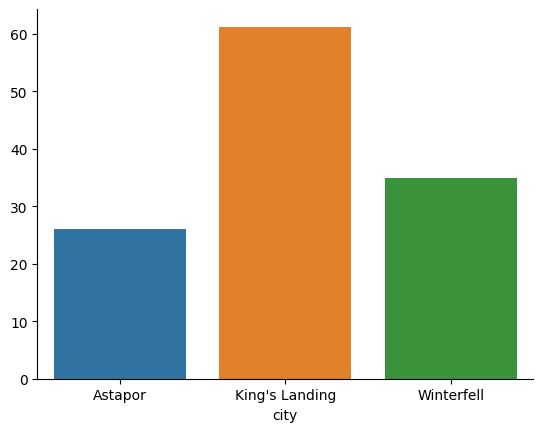

In [8]:
#churn зав от city? - 
#номин/номин - chi2
#barplot
bar = df[df.churn=='churn'].groupby('city').size() / df.groupby('city').size()
bar = bar.mul(100)
sns.barplot(x=bar.index, y=bar.values)
sns.despine()

In [9]:
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,4298,6206,8171
not_churn,12137,3721,14919


In [10]:
#таксисты в игре престолов... ладно

In [11]:
#требования
#1. Все наблюдения независимы
#2. Количество наблюдений в каждой ячейке больше 5

In [12]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [13]:
p<=0.05
#отклоняем H0 о независимости от города

True

Для проверки этой гипотезы я использую `ХИ-КВАДРАТ`, поскольку переменные: `ОБЕ КАТЕГОРИАЛЬНЫЕ`. Нулевая гипотеза `ОТКЛОНЯЕТСЯ`, поскольку `p-value < 0. 05`. Значит, `ВЗАИМОСВЯЗЬ ЕСТЬ`.

## Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Проверим распределение на нормальность:
```python
from scipy.stats import shapiro
```

Не забудьте использовать .sample(1000).

In [14]:
#зависимость поездок в первый месяц   от   города
# numerical/categorical - Anova

чек требований 
<br>1 дисп levene 
<br>2 если выборки<30 то shapiro - у нас >30
<br>2 если не равн размер выборок то shapiro - но у нас не равные выборки

In [15]:
pg.homoscedasticity(data=df, dv='trips_in_first_30_days', 
                          group='city')

,W,pval,equal_var
levene,98.098728,3.017436e-43,False


In [16]:
city = [x for x in df.city.unique()]
dfshap = [0] * 3
s=[0]*3

for i in [*range(3)]:
    s[i] = df[df.city==city[i]].trips_in_first_30_days
    print(ss.shapiro(s[i].sample(1000, replace=True, random_state=17)))

ShapiroResult(statistic=0.5591932535171509, pvalue=1.961817850054744e-44)
ShapiroResult(statistic=0.607285737991333, pvalue=1.0047309989208938e-42)
ShapiroResult(statistic=0.6106932163238525, pvalue=1.3508517196091237e-42)


Левен не пройден, Шапиро не пройден => нужен Kruskal

* Распределения не являются нормальными, поэтому используем ANOVA
* **Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса**
* Распределения являются нормальными, поэтому используем ANOVA
* Распределения являются нормальными, поэтому используем t-test
* Распределения являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса

## Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [17]:
kruskal(s[0], s[1], s[2])

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

In [18]:
#откл H0
#хотя бы одна пара ср отличается
#город влияет на количество поездок

Обнаружены ли статистически значимые различия?

* **Да**
* Нет

## Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [19]:
#categ(2lvl-s) и numer переменные - номинативная разделяет на 2 выборки 
# используем T-test 
#можно было быприменить логистическую регрессию, но модель оказалась
#ненадежной(R-sq = 0.03)

In [20]:
churn = df[df.churn == 'churn'].trips_in_first_30_days
not_churn = df[df.churn == 'not_churn'].trips_in_first_30_days

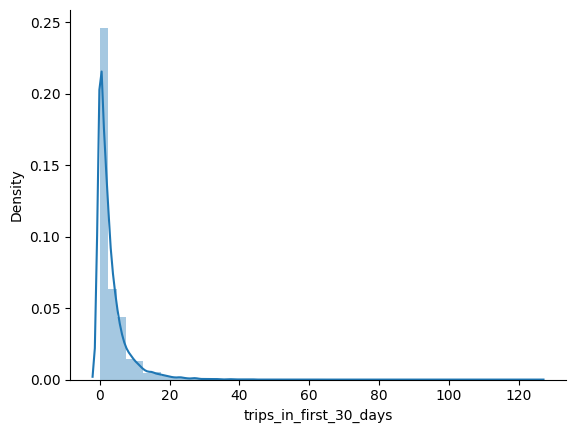

In [21]:
sns.distplot(churn)
sns.despine()

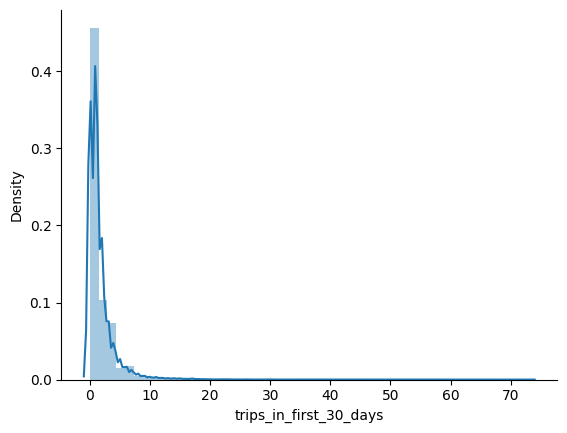

In [22]:
sns.distplot(not_churn)
sns.despine()

In [23]:
mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=341629370.5, pvalue=3.0609441759773124e-288)

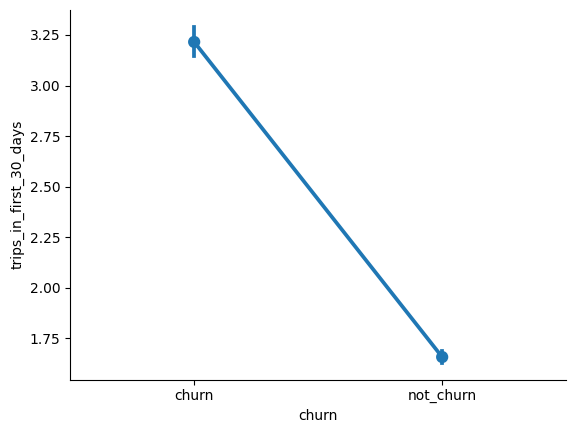

In [24]:
sns.pointplot(x='churn', y='trips_in_first_30_days', data=df)
sns.despine()

Распределение переменной trips_in_first_30_days `НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ`, поэтому для проверки гипотезы я использую `U-КРИТЕРИЙ МАННА-УИТНИ`. Результат оказался статистически `ЗНАЧИМ`. Значит, `ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ, УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ`.